Ce notebook constitue, une exploration des possibilités d'amélioration du précédent.

In [1]:
# Import des librairies manipulation des données
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [2]:
# Import librairie machine learning
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, median_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Import des librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

/home/fienno/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <font color=red>Chargement et analyse exploratoire des données:</font>

Dans cet partie, nous sélectionnerons les observations correspondantes au type de locaux qui nous intéressent.

Dans ce cas-ci, nous traiterons différemment les valeurs manquantes et les outliers.

In [4]:
# Lecture des données
df = pd.read_table('valeursfoncieres-2019.txt', sep='|')

/home/fienno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# 3 premières observations du dataset
print("Les 3 premières observations du jeu de données: ")
print(df.head(3))
print('\n')
# dimensions globales du fichier
print('Le fichier comporte {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))
print('\n')
print("La liste des intitulés des colomnes: ")
print(df.columns)
print('\n')
# Identifier les lignes et colonnes vides 
print("Identifions et comptons le nobmre d'observations vides du jeu de données: ")
print(df.isna().sum())

Les 3 premières observations du jeu de données: 
   Code service CH  Reference document  1 Articles CGI  2 Articles CGI  \
0              NaN                 NaN             NaN             NaN   
1              NaN                 NaN             NaN             NaN   
2              NaN                 NaN             NaN             NaN   

   3 Articles CGI  4 Articles CGI  5 Articles CGI  No disposition  \
0             NaN             NaN             NaN               1   
1             NaN             NaN             NaN               1   
2             NaN             NaN             NaN               1   

  Date mutation Nature mutation  ... Surface Carrez du 5eme lot  \
0    04/01/2019           Vente  ...                        NaN   
1    04/01/2019           Vente  ...                        NaN   
2    04/01/2019           Vente  ...                        NaN   

   Nombre de lots Code type local   Type local Identifiant local  \
0               1             2.0  Appar

# <font color=red>Traitement des données.</font>

L'analyse précédente nous a confirmé l'existence de colonnes vides et d'observations manquantes dans 
plusieurs de celles qui nous intéressent.
Dans ce notebook, nous allons supprimer les colonnes vides, puis celles ne comportant pas un nombre suffisant de données (50%), nous identifierons puis traiteront les outliers.

In [6]:
print("Suppression des colonnes vides")
dfNaN = df.dropna(axis=1, how='all')
print("\n")
print("Vérification de la suppression effective des colonnes vides")
print(dfNaN.isna().sum())

Suppression des colonnes vides


Vérification de la suppression effective des colonnes vides
No disposition                      0
Date mutation                       0
Nature mutation                     0
Valeur fonciere                 29261
No voie                       1025638
B/T/Q                         2426362
Type de voie                  1053720
Code voie                       28189
Voie                            28354
Code postal                     28323
Commune                             0
Code departement                    0
Code commune                        0
Prefixe de section            2408956
Section                            74
No plan                             0
No Volume                     2529165
1er lot                       1753172
Surface Carrez du 1er lot     2314726
2eme lot                      2372713
Surface Carrez du 2eme lot    2481517
3eme lot                      2509709
Surface Carrez du 3eme lot    2530577
4eme lot                      252

Sélectionner des observations qui nous intéressent:
il s'agit pour la colonne `Nature de la mutation` des `Vente en l'état futur d'achèvement`
et les colonnes 36 et 37: sélectionner les appartements (type 2) et maisons (type 1)

####  Détermination du contenu de chaque colonne d'intérêt:

In [7]:
# colonne Nature de la mutation
print("Liste des valeurs distinctes dans la colonne Nature de la mutation:")
print(dfNaN['Nature mutation'].unique())
print("Nombre de valeurs unique: ")
print(dfNaN['Nature mutation'].nunique())
print('\n')
print("Liste des valeurs distinctes dans la colonne Code Type local:")
print(dfNaN['Code type local'].unique())
print("Nombre de valeurs unique: ")
print(dfNaN['Code type local'].nunique())
print('\n')
print("Liste des valeurs distinctes dans la colonne Type local:")
print(dfNaN['Type local'].unique())
print("Nombre de valeurs unique: ")
print(dfNaN['Type local'].nunique())
print('\n')
print("Liste des valeurs distinctes dans la colonne Date mutation: ")
print(dfNaN['Date mutation'].unique())
print("Nombre de valeurs unique: ")
print(dfNaN['Date mutation'].nunique())

Liste des valeurs distinctes dans la colonne Nature de la mutation:
['Vente' 'Echange' 'Vente terrain à bâtir'
 "Vente en l'état futur d'achèvement" 'Adjudication' 'Expropriation']
Nombre de valeurs unique: 
6


Liste des valeurs distinctes dans la colonne Code Type local:
[ 2.  3.  1. nan  4.]
Nombre de valeurs unique: 
4


Liste des valeurs distinctes dans la colonne Type local:
['Appartement' 'Dépendance' 'Maison' nan
 'Local industriel. commercial ou assimilé']
Nombre de valeurs unique: 
4


Liste des valeurs distinctes dans la colonne Date mutation: 
['04/01/2019' '08/01/2019' '07/01/2019' '03/01/2019' '12/01/2019'
 '09/01/2019' '15/01/2019' '11/01/2019' '16/01/2019' '21/01/2019'
 '10/01/2019' '17/01/2019' '18/01/2019' '14/01/2019' '23/01/2019'
 '24/01/2019' '22/01/2019' '25/01/2019' '28/01/2019' '31/01/2019'
 '29/01/2019' '30/01/2019' '01/02/2019' '04/02/2019' '05/02/2019'
 '13/02/2019' '08/02/2019' '07/02/2019' '12/02/2019' '11/02/2019'
 '06/02/2019' '14/02/2019' '15/02/2019' '1

####   Sélection et informations sur les colonnes d'intérêt

In [8]:
dfNaN_VEFA = dfNaN[dfNaN['Nature mutation'] == "Vente en l'état futur d'achèvement"]
print("Dimension du jeu de données restreint aux observations VEFA de la colonne Nature de la mutation. \n")
print('Ce jeu de données comporte', dfNaN_VEFA.shape[0],'lignes et',dfNaN_VEFA.shape[1],'colonnes liées au VEFA.')
print('\n')
dfNaN_appart_maison = dfNaN[(dfNaN['Nature mutation'] == "Vente en l'état futur d'achèvement") & ((dfNaN['Type local'] == "Appartement") | (dfNaN['Type local'] == "Maison"))]
print("Ensuite les dimensions du jeu de données restreint aux observations VEFA de la colonne Nature de la mutation et des appartements et maisons de la colonnes Type local. \n")
print('Ce dernier comporte', dfNaN_appart_maison.shape[0],'lignes et',dfNaN_appart_maison.shape[1],'colonnes liées au VEFA pour les appartements et les maisons.')
print("C'est donc sur ces données que nous allons porter notre attention.")
print('Nom des colonnes: \n')
print(dfNaN_appart_maison.columns)
print('\n')
print("Quelques informations sur les types des données contenues dans les différentes colonnes: \n")
print(dfNaN_appart_maison.info())
print('\n')

Dimension du jeu de données restreint aux observations VEFA de la colonne Nature de la mutation. 

Ce jeu de données comporte 185441 lignes et 35 colonnes liées au VEFA.


Ensuite les dimensions du jeu de données restreint aux observations VEFA de la colonne Nature de la mutation et des appartements et maisons de la colonnes Type local. 

Ce dernier comporte 6663 lignes et 35 colonnes liées au VEFA pour les appartements et les maisons.
C'est donc sur ces données que nous allons porter notre attention.
Nom des colonnes: 

Index(['No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot

In [9]:
print('Suppression des colonnes pour lesquelles plus de la moitié des valeurs sont manquantes')
colonnes = dfNaN_appart_maison.columns[dfNaN_appart_maison.isnull().sum() > 1000]
print(colonnes)
print('\n')
print("Nombre de colonnes à supprimer: ", len(colonnes))
dfAppartMaisonDrop = dfNaN_appart_maison.drop(colonnes, axis = 1)
print('\n')
print("Le jeu de données comporte", dfAppartMaisonDrop.shape[0], "lignes et", dfAppartMaisonDrop.shape[1], 'colonnes.')

Suppression des colonnes pour lesquelles plus de la moitié des valeurs sont manquantes
Index(['No voie', 'B/T/Q', 'Prefixe de section', 'No Volume',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nature culture', 'Nature culture speciale', 'Surface terrain'],
      dtype='object')


Nombre de colonnes à supprimer:  16


Le jeu de données comporte 6663 lignes et 19 colonnes.


In [10]:
print("Identifions le nombre de cellules vides par colonnes:")
print(dfAppartMaisonDrop.isnull().sum())

Identifions le nombre de cellules vides par colonnes:
No disposition                 0
Date mutation                  0
Nature mutation                0
Valeur fonciere               13
Type de voie                 875
Code voie                      0
Voie                           1
Code postal                    2
Commune                        0
Code departement               0
Code commune                   0
Section                        0
No plan                        0
1er lot                      399
Nombre de lots                 0
Code type local                0
Type local                     0
Surface reelle bati            3
Nombre pieces principales      3
dtype: int64


In [11]:
print('Suppression des 13 observations pour lesquelles les valeurs foncières sont manquantes.')
dfAppartMaisonDrop['Valeur fonciere'].replace({None: 'XXX'}, inplace=True)
indexOutliers = dfAppartMaisonDrop[dfAppartMaisonDrop['Valeur fonciere'] == 'XXX'].index
dfAppartMaisonDrop.drop(indexOutliers, inplace = True)
print('\n')
print("Vérification du bon déroulemet de l'opération")
dfAppartMaisonDrop.isnull().sum()

Suppression des 13 observations pour lesquelles les valeurs foncières sont manquantes.


Vérification du bon déroulemet de l'opération


No disposition                 0
Date mutation                  0
Nature mutation                0
Valeur fonciere                0
Type de voie                 875
Code voie                      0
Voie                           1
Code postal                    2
Commune                        0
Code departement               0
Code commune                   0
Section                        0
No plan                        0
1er lot                      386
Nombre de lots                 0
Code type local                0
Type local                     0
Surface reelle bati            3
Nombre pieces principales      3
dtype: int64

In [12]:
print("Informations sur le nouveau jeu de données.")
dfAppartMaisonDrop.info()

Informations sur le nouveau jeu de données.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   int64  
 1   Date mutation              6650 non-null   object 
 2   Nature mutation            6650 non-null   object 
 3   Valeur fonciere            6650 non-null   object 
 4   Type de voie               5775 non-null   object 
 5   Code voie                  6650 non-null   object 
 6   Voie                       6649 non-null   object 
 7   Code postal                6648 non-null   float64
 8   Commune                    6650 non-null   object 
 9   Code departement           6650 non-null   object 
 10  Code commune               6650 non-null   int64  
 11  Section                    6650 non-null   object 
 12  No plan                    6650 non-null   int64  
 13 

In [13]:
dfAppartMaisonDrop.head(3)

,No disposition,Date mutation,Nature mutation,Valeur fonciere,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales
647,1,25/01/2019,Vente en l'état futur d'achèvement,"2040000,00",NaN,B116,LE FORT,1440.0,VIRIAT,1,451,BK,100,NaN,0,1.0,Maison,95.0,3.0
1748,1,08/03/2019,Vente en l'état futur d'achèvement,"210000,00",RUE,2880,DU PALAIS,1000.0,BOURG-EN-BRESSE,1,53,AD,339,6,1,2.0,Appartement,63.0,2.0
2046,1,19/03/2019,Vente en l'état futur d'achèvement,"129000,00",AV,0231,DES ANCIENS COMBATTANTS,1000.0,BOURG-EN-BRESSE,1,53,AE,320,11,1,2.0,Appartement,21.0,1.0


In [14]:
print("Suppression des colonnes Nature mutation, Code commune, No plan et Code type local")
dfAppartMaisonDrop.drop(['Nature mutation', 'Code commune', 'No plan', 'Code type local'],axis = 1, inplace = True)

Suppression des colonnes Nature mutation, Code commune, No plan et Code type local


In [15]:
dfAppartMaisonDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   int64  
 1   Date mutation              6650 non-null   object 
 2   Valeur fonciere            6650 non-null   object 
 3   Type de voie               5775 non-null   object 
 4   Code voie                  6650 non-null   object 
 5   Voie                       6649 non-null   object 
 6   Code postal                6648 non-null   float64
 7   Commune                    6650 non-null   object 
 8   Code departement           6650 non-null   object 
 9   Section                    6650 non-null   object 
 10  1er lot                    6264 non-null   object 
 11  Nombre de lots             6650 non-null   int64  
 12  Type local                 6650 non-null   object 
 13  Surface reelle bati        6647 non-null   

In [16]:
print("Modification du type de donnée des colonnes 'No disposition', 'Code postal'")
dfAppartMaisonDrop[['No disposition', 'Code postal', '1er lot']] = dfAppartMaisonDrop[['No disposition', 'Code postal', '1er lot']].astype(str)
print('\n')
print("Vérification que l'opération s'est bien déroulée")
dfAppartMaisonDrop.info()

Modification du type de donnée des colonnes 'No disposition', 'Code postal'


Vérification que l'opération s'est bien déroulée
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Date mutation              6650 non-null   object 
 2   Valeur fonciere            6650 non-null   object 
 3   Type de voie               5775 non-null   object 
 4   Code voie                  6650 non-null   object 
 5   Voie                       6649 non-null   object 
 6   Code postal                6650 non-null   object 
 7   Commune                    6650 non-null   object 
 8   Code departement           6650 non-null   object 
 9   Section                    6650 non-null   object 
 10  1er lot                    6650 non-null   object 
 11  Nombre de lots             6

#### Imputation des données manquantes

In [17]:
dfAppartMaisonDrop['Voie'] = dfAppartMaisonDrop['Voie'].fillna(dfAppartMaisonDrop['Voie'].mode()[0])
#
dfAppartMaisonDrop['Type de voie'] = dfAppartMaisonDrop['Type de voie'].fillna(dfAppartMaisonDrop['Type de voie'].mode()[0])
#
dfAppartMaisonDrop['Code postal'] = dfAppartMaisonDrop['Code postal'].fillna(dfAppartMaisonDrop['Code postal'].mode()[0])
#
dfAppartMaisonDrop['1er lot'] = dfAppartMaisonDrop['1er lot'].fillna(dfAppartMaisonDrop['1er lot'].mode()[0])

 Nous allons opérer une imputation par groupe pour les colonnes Nombre pieces principales et Surface relle bati

In [18]:
print('Nombre de valeurs uniques dans la colonne Type local', dfAppartMaisonDrop['Type local'].nunique())
print('Nombre de valeurs uniques dans la colonne Nombre pieces principales', dfAppartMaisonDrop['Nombre pieces principales'].nunique())
print('Nombre de valeurs uniques dans la colonne Surface reelle bati', dfAppartMaisonDrop['Surface reelle bati'].nunique())
print('\n')
par_type_local = dfAppartMaisonDrop.groupby('Type local')
## definition de la  fonction d'imputation
def impute_median(series):
    return series.fillna(series.median())
#
dfAppartMaisonDrop['Nombre pieces principales'] = par_type_local['Nombre pieces principales'].transform(impute_median)
dfAppartMaisonDrop['Surface reelle bati'] = par_type_local['Surface reelle bati'].transform(impute_median)

Nombre de valeurs uniques dans la colonne Type local 2
Nombre de valeurs uniques dans la colonne Nombre pieces principales 13
Nombre de valeurs uniques dans la colonne Surface reelle bati 159




In [19]:
print("Vérification que l'opération s'est bien déroulée.")
dfAppartMaisonDrop.isna().sum()

Vérification que l'opération s'est bien déroulée.


No disposition               0
Date mutation                0
Valeur fonciere              0
Type de voie                 0
Code voie                    0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Section                      0
1er lot                      0
Nombre de lots               0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
dtype: int64

In [20]:
dfAppartMaisonDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Date mutation              6650 non-null   object 
 2   Valeur fonciere            6650 non-null   object 
 3   Type de voie               6650 non-null   object 
 4   Code voie                  6650 non-null   object 
 5   Voie                       6650 non-null   object 
 6   Code postal                6650 non-null   object 
 7   Commune                    6650 non-null   object 
 8   Code departement           6650 non-null   object 
 9   Section                    6650 non-null   object 
 10  1er lot                    6650 non-null   object 
 11  Nombre de lots             6650 non-null   int64  
 12  Type local                 6650 non-null   object 
 13  Surface reelle bati        6650 non-null   

In [21]:
print("Colonne valeurs foncière qui deviendra numerique.")
def change_type_VF(data):
    data['Valeur fonciere'] = data['Valeur fonciere'].apply(lambda x: x.replace(',', '.'))
    data['Valeur fonciere'] = data['Valeur fonciere'].astype(float)
    return data

dfAppartMaisonDrop = change_type_VF(dfAppartMaisonDrop)

Colonne valeurs foncière qui deviendra numerique.


In [22]:
dfAppartMaisonDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Date mutation              6650 non-null   object 
 2   Valeur fonciere            6650 non-null   float64
 3   Type de voie               6650 non-null   object 
 4   Code voie                  6650 non-null   object 
 5   Voie                       6650 non-null   object 
 6   Code postal                6650 non-null   object 
 7   Commune                    6650 non-null   object 
 8   Code departement           6650 non-null   object 
 9   Section                    6650 non-null   object 
 10  1er lot                    6650 non-null   object 
 11  Nombre de lots             6650 non-null   int64  
 12  Type local                 6650 non-null   object 
 13  Surface reelle bati        6650 non-null   

#### À ce stade, nous avons 15 variables et une cible

In [24]:
print("Transformation des informations de la colonne Date mutation")
dfAppartMaisonDrop['Jour'] = dfAppartMaisonDrop['Date mutation'].apply(lambda x: x[0:2])
dfAppartMaisonDrop['Mois'] = dfAppartMaisonDrop['Date mutation'].apply(lambda x: x[3:5])
dfAppartMaisonDrop['Annee'] = dfAppartMaisonDrop['Date mutation'].apply(lambda x: x[6:])
print("Suppression de la colonne Date mutation")
dfAppartMaisonDrop = dfAppartMaisonDrop.drop('Date mutation', axis = 1)
print("Vérification des données")
dfAppartMaisonDrop.info()

Transformation des informations de la colonne Date mutation
Suppression de la colonne Date mutation
Vérification des données
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Valeur fonciere            6650 non-null   float64
 2   Type de voie               6650 non-null   object 
 3   Code voie                  6650 non-null   object 
 4   Voie                       6650 non-null   object 
 5   Code postal                6650 non-null   object 
 6   Commune                    6650 non-null   object 
 7   Code departement           6650 non-null   object 
 8   Section                    6650 non-null   object 
 9   1er lot                    6650 non-null   object 
 10  Nombre de lots             6650 non-null   int64  
 11  Type local                 665

In [26]:
print("Liste des valeurs distinctes dans la colonne Annee: ")
print(dfAppartMaisonDrop['Annee'].unique())
print("Nombre de valeurs unique: ")
print(dfAppartMaisonDrop['Annee'].nunique())

Liste des valeurs distinctes dans la colonne Annee: 
['2019']
Nombre de valeurs unique: 
1


In [27]:
print('Suppression de la colonne Annee')
dfAppartMaisonDrop = dfAppartMaisonDrop.drop('Annee', axis = 1)
print("Vérification des données")
dfAppartMaisonDrop.info()

Suppression de la colonne Annee
Vérification des données
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Valeur fonciere            6650 non-null   float64
 2   Type de voie               6650 non-null   object 
 3   Code voie                  6650 non-null   object 
 4   Voie                       6650 non-null   object 
 5   Code postal                6650 non-null   object 
 6   Commune                    6650 non-null   object 
 7   Code departement           6650 non-null   object 
 8   Section                    6650 non-null   object 
 9   1er lot                    6650 non-null   object 
 10  Nombre de lots             6650 non-null   int64  
 11  Type local                 6650 non-null   object 
 12  Surface reelle bati        6650 non-null  

### <font color=blue>Analyse exploratoire du jeu de données issu de cette transformation</font>

#### <font color=blue>Visualisation de certaines variables</font>

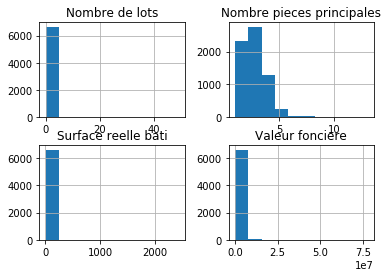

In [28]:
dfAppartMaisonDrop.hist()
plt.show()

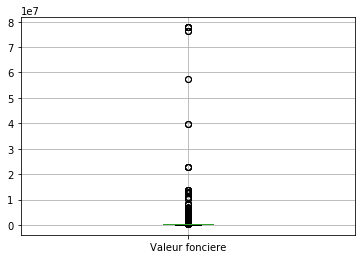

In [24]:
dfAppartMaisonDrop[['Valeur fonciere']].boxplot()
plt.show()

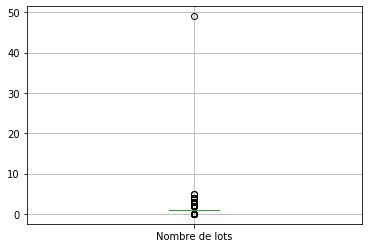

In [25]:
dfAppartMaisonDrop[['Nombre de lots']].boxplot()
plt.show()

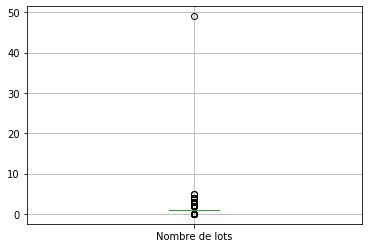

In [26]:
dfAppartMaisonDrop[['Nombre de lots']].boxplot()
plt.show()

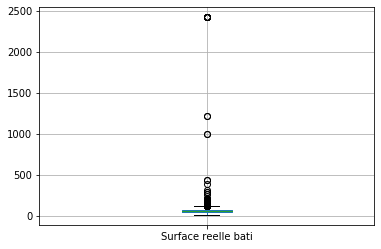

In [27]:
dfAppartMaisonDrop[['Surface reelle bati']].boxplot()
plt.show()

#### <font color=blue>Statistque descriptive</font>

In [28]:
dfAppartMaisonDrop.describe()

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales
count,6.650000e+03,6650.000000,6650.000000,6650.000000
mean,5.268695e+05,1.109173,65.708571,2.866165
std,3.289479e+06,0.790295,89.244399,1.021861
min,1.000000e+00,0.000000,9.000000,1.000000
25%,1.735028e+05,1.000000,44.000000,2.000000
50%,2.260000e+05,1.000000,61.000000,3.000000
75%,3.071196e+05,1.000000,74.000000,3.000000
max,7.780800e+07,49.000000,2426.000000,13.000000


### <font color=green>Détection des outliers et traitement des outliers</font>

In [ ]:
Nous allons utiliser la méthode de winsorization.

In [29]:
dfAppartMaisonDrop['Nombre pieces principales'] = winsorize(dfAppartMaisonDrop['Nombre pieces principales'], limits = [0.05, 0.1])
dfAppartMaisonDrop['Surface reelle bati'] = winsorize(dfAppartMaisonDrop['Surface reelle bati'], limits = [0.05, 0.1])
dfAppartMaisonDrop['Nombre de lots'] = winsorize(dfAppartMaisonDrop['Nombre de lots'], limits = [0.05, 0.1])

#### <font color=blue>Visualisation de certaines variables après winsorize</font>

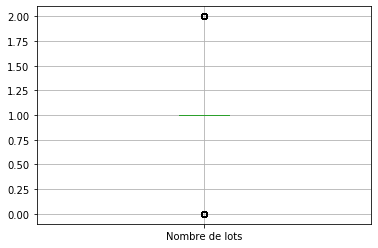

In [30]:
dfAppartMaisonDrop[['Nombre de lots']].boxplot()
plt.show()

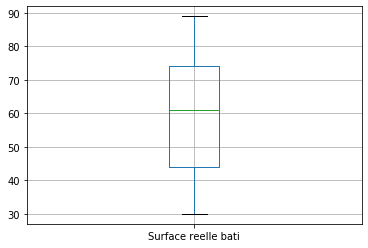

In [30]:
dfAppartMaisonDrop[['Surface reelle bati']].boxplot()
plt.show()

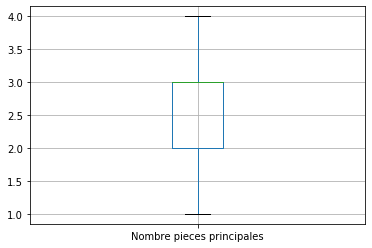

In [35]:
dfAppartMaisonDrop[['Nombre pieces principales']].boxplot()
plt.show()

### <font color=green>Séparation des variables en deux groupes</font>

In [31]:
dfAppartMaisonDrop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   No disposition             6650 non-null   object 
 1   Valeur fonciere            6650 non-null   float64
 2   Type de voie               6650 non-null   object 
 3   Code voie                  6650 non-null   object 
 4   Voie                       6650 non-null   object 
 5   Code postal                6650 non-null   object 
 6   Commune                    6650 non-null   object 
 7   Code departement           6650 non-null   object 
 8   Section                    6650 non-null   object 
 9   1er lot                    6650 non-null   object 
 10  Nombre de lots             6650 non-null   int64  
 11  Type local                 6650 non-null   object 
 12  Surface reelle bati        6650 non-null   float64
 13  Nombre pieces principales  6650 non-null   

### <font color=black>Variable qualitative</font>

In [32]:
print("DataFrame des variables qualitatives.")
dfAppartMaisonDropQualitatif = dfAppartMaisonDrop.select_dtypes(include ='object')

DataFrame des variables qualitatives.


In [33]:
dfAppartMaisonDropQualitatif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   No disposition    6650 non-null   object
 1   Type de voie      6650 non-null   object
 2   Code voie         6650 non-null   object
 3   Voie              6650 non-null   object
 4   Code postal       6650 non-null   object
 5   Commune           6650 non-null   object
 6   Code departement  6650 non-null   object
 7   Section           6650 non-null   object
 8   1er lot           6650 non-null   object
 9   Type local        6650 non-null   object
 10  Jour              6650 non-null   object
 11  Mois              6650 non-null   object
dtypes: object(12)
memory usage: 675.4+ KB


In [34]:
dfAppartMaisonDropQualitatif.describe()

,No disposition,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Section,1er lot,Type local,Jour,Mois
count,6650,6650,6650,6650,6650,6650,6650,6650,6650,6650,6650,6650
unique,2,34,1327,1861,890,933,83,247,849,2,31,12
top,1,RUE,1120,BAJOT,31200.0,TOULOUSE,31,AB,nan,Appartement,28,03
freq,6617,4045,77,76,114,244,527,288,386,6206,318,960


In [35]:
dfAppartMaisonDropQualitatif.isna().sum()

No disposition      0
Type de voie        0
Code voie           0
Voie                0
Code postal         0
Commune             0
Code departement    0
Section             0
1er lot             0
Type local          0
Jour                0
Mois                0
dtype: int64

In [36]:
print("Changement de l'encodage pour construction du modèle.")
dummy_dfAppartMaisonDropQualitatif = pd.get_dummies(dfAppartMaisonDropQualitatif)

Changement de l'encodage pour construction du modèle.


In [37]:
print("Information sur ces variables")
print(dummy_dfAppartMaisonDropQualitatif.info())

Information sur ces variables
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Columns: 6271 entries, No disposition_1 to Mois_12
dtypes: uint8(6271)
memory usage: 39.8 MB
None


In [38]:
dummy_dfAppartMaisonDropQualitatif[45:47]

,No disposition_1,No disposition_2,Type de voie_ACH,Type de voie_ALL,Type de voie_AV,Type de voie_BD,Type de voie_CHE,Type de voie_CHEM,Type de voie_CITE,Type de voie_CLOS,...,Mois_03,Mois_04,Mois_05,Mois_06,Mois_07,Mois_08,Mois_09,Mois_10,Mois_11,Mois_12
10660,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10925,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### <font color=black>Variable quantitative</font>

In [39]:
print("DataFrame des variables quantitatives.")
dfAppartMaisonDropQuantitatif = dfAppartMaisonDrop.select_dtypes(include ='number')

DataFrame des variables quantitatives.


In [40]:
dfAppartMaisonDropQuantitatif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Valeur fonciere            6650 non-null   float64
 1   Nombre de lots             6650 non-null   int64  
 2   Surface reelle bati        6650 non-null   float64
 3   Nombre pieces principales  6650 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 259.8 KB


In [33]:
dfAppartMaisonDropQuantitatif[45:47]

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales
10660,534400.0,1,89.0,4.0
10925,475000.0,1,85.0,4.0


In [34]:
dfAppartMaisonDropQuantitatif.head(3)

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales
647,2040000.0,0,89.0,3.0
1748,210000.0,1,63.0,2.0
2046,129000.0,1,30.0,1.0


In [35]:
dfAppartMaisonDropQuantitatif.describe()

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales
count,6.650000e+03,6650.000000,6650.000000,6650.000000
mean,5.268695e+05,1.070677,60.636241,2.807519
std,3.289479e+06,0.426379,17.653928,0.876802
min,1.000000e+00,0.000000,30.000000,1.000000
25%,1.735028e+05,1.000000,44.000000,2.000000
50%,2.260000e+05,1.000000,61.000000,3.000000
75%,3.071196e+05,1.000000,74.000000,3.000000
max,7.780800e+07,2.000000,89.000000,4.000000


#### <font color=blue>Normalisation des variables quantitatives</font>

In [41]:
scaler = StandardScaler()

In [42]:
nlot = scaler.fit(dfAppartMaisonDropQuantitatif[['Nombre de lots']])
narea = scaler.fit(dfAppartMaisonDropQuantitatif[['Surface reelle bati']])
npiece = scaler.fit(dfAppartMaisonDropQuantitatif[['Nombre pieces principales']])

In [43]:
dfAppartMaisonDropQuantitatif['Nombre de lots'] = nlot.transform(dfAppartMaisonDropQuantitatif[['Nombre de lots']])
dfAppartMaisonDropQuantitatif['Surface reelle bati'] = narea.transform(dfAppartMaisonDropQuantitatif[['Surface reelle bati']])
dfAppartMaisonDropQuantitatif['Nombre pieces principales'] = npiece.transform(dfAppartMaisonDropQuantitatif[['Nombre pieces principales']])

/home/fienno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/fienno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fienno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [44]:
dfAppartMaisonDropQuantitatif.describe()

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales
count,6.650000e+03,6650.000000,6650.000000,6.650000e+03
mean,5.268695e+05,-1.981033,65.959137,-1.196704e-16
std,3.289479e+06,0.486326,20.135977,1.000075e+00
min,1.000000e+00,-3.202241,31.015601,-2.061646e+00
25%,1.735028e+05,-2.061646,46.983928,-9.210517e-01
50%,2.260000e+05,-2.061646,66.374039,2.195431e-01
75%,3.071196e+05,-2.061646,81.201771,2.195431e-01
max,7.780800e+07,-0.921052,98.310692,1.360138e+00


### <font color=blue>Fusion des deux dataframe.</font>

In [45]:
print("Fusion des deux dataframe quali et quanti en un seul.")
dfFusion_QalQant = pd.merge(dfAppartMaisonDropQuantitatif,dummy_dfAppartMaisonDropQualitatif, right_index=True, left_index=True)

Fusion des deux dataframe quali et quanti en un seul.


In [46]:
dfFusion_QalQant.head(3)

,Valeur fonciere,Nombre de lots,Surface reelle bati,Nombre pieces principales,No disposition_1,No disposition_2,Type de voie_ACH,Type de voie_ALL,Type de voie_AV,Type de voie_BD,...,Mois_03,Mois_04,Mois_05,Mois_06,Mois_07,Mois_08,Mois_09,Mois_10,Mois_11,Mois_12
647,2040000.0,-3.202241,98.310692,0.219543,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1748,210000.0,-2.061646,68.655228,-0.921052,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2046,129000.0,-2.061646,31.015601,-2.061646,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [47]:
print("Dimension du nouveau jeu de données: ", dfFusion_QalQant.shape[0], "lignes", dfFusion_QalQant.shape[1], "colonnes")
print("Informations sur le type des données.")
dfFusion_QalQant.info()

Dimension du nouveau jeu de données:  6650 lignes 6275 colonnes
Informations sur le type des données.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 647 to 2527552
Columns: 6275 entries, Valeur fonciere to Mois_12
dtypes: float64(4), uint8(6271)
memory usage: 40.3 MB


# <font color=red>Modélisation et évaluation.</font>

Notre choix de modèle portera, comme dans le cas précédent, sur:
- Un arbre de décision
- Une forêt d'arbre de décision.
- Un arbre décision randomisé
- Un arbre de décision 'boosté'

### <font color=blue>Sélection de variables.</font>

Une observation claire pour nous est le nombre pléthorique de variable au regard du nombre d'observations.
Ceci fera l'objet d'un travail ultérieur.

In [185]:
"""
RFE: Feature selection
"""
"""
print("Selection with Decision Tree Regressor")
tree = DecisionTreeRegressor()
selecteur = RFE(estimator = tree, n_features_to_select = 75)  # on peut choisir le nombre de feature n_features_to_select = ....
sol = selecteur.fit(X_train, y_train)
print(sol.n_features_)
print("Identification des variables les plus pertinentes")
variables = list(zip(sol.support_, X.columns))
interval = 15
indexe = 5910
variables[indexe:indexe + interval]
print(sol.support_)
print(sol.ranking_)
"""

"""
X_train_new = X_train[:, sol.support_]
print(X_train_new.shape)
X_test_new = X_test[:, sol.support_]

"""

'\nX_train_new = X_train[:, sol.support_]\nprint(X_train_new.shape)\nX_test_new = X_test[:, sol.support_]\n\n'

In [48]:
print("Coefficient de correlation de Peason's")
cor = dfFusion_QalQant.corr()
cor_target = abs(cor['Valeur fonciere'])

Coefficient de correlation de Peason's


In [90]:
print("Selection des variables en fonction d'un seuil")
seuil = 0.0092
print("seuil = ", seuil)
best_features = cor_target[cor_target > seuil]
print("Pour un seuil de:", seuil, ", il y a:", len(best_features), "variables.")

Selection des variables en fonction d'un seuil
seuil =  0.0092
Pour un seuil de: 0.0092 , il y a: 198 variables.


In [91]:
dfSelected = dfFusion_QalQant[list(set(best_features.index))]
X = dfSelected.drop('Valeur fonciere', axis = 1)
y = dfSelected['Valeur fonciere']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123, test_size=0.2)

In [92]:
X_train.shape

(5320, 197)

#### <font color=blue>Modéle et Mesure de performance du modèle.</font>

In [83]:
reel = y_test

In [77]:
def performance(algo_name,reel, predit):
    mae = round(mean_absolute_error(reel,predit),2)
    mdae = round(median_absolute_error(reel,predit), 2)
    r2 = round(r2_score(reel, predit), 2)
    return algo_name,mae, mdae, r2

##### <font color=black>Warning !!.</font>
S'assurer lorsqu'on choisit une modélisation avec toutes les variables (X_train, X_test) ou avec sélection de variable (X_train_new, X_test_new) d'effectuer les changements.

##### <font color=black>Extra Trees Regressor.</font>

In [93]:
def trainXtreeRegressor(X,y):
    treeR = ExtraTreesRegressor(random_state=0).fit(X,y)
    return  treeR
modelT = trainXtreeRegressor(X_train, y_train)

In [94]:
algo_name = "Extra Tree Regressor"
y_pred=modelT.predict(X_test)
predit = y_pred
print(algo_name)
print("Mean Absolute Error: ", performance(algo_name, reel, predit)[1])
print("Median absolute error: ", performance(algo_name, reel, predit)[2])
print("R2 score: ", performance(algo_name, reel, predit)[3])

Extra Tree Regressor
Mean Absolute Error:  120238.38
Median absolute error:  34141.25
R2 score:  0.93


##### <font color=black>Gradient Boosting Regressor.</font>

In [95]:
def trainGradient(X,y):
    grad = GradientBoostingRegressor(random_state=0).fit(X,y)
    return grad
modelG = trainGradient(X_train, y_train)

In [96]:
algo_name = "Gradient Regressor"
y_pred=modelG.predict(X_test)
predit = y_pred
print(algo_name)
print("Mean Absolute Error: ", performance(algo_name, reel, predit)[1])
print("Median absolute error: ", performance(algo_name, reel, predit)[2])
print("R2: ", performance(algo_name, reel, predit)[3])

Gradient Regressor
Mean Absolute Error:  193621.64
Median absolute error:  82021.07
R2:  0.93


##### <font color=black>Random Forest Regressor.</font>

In [97]:
def trainRFRegressor(X,y):
    rfR = RandomForestRegressor(max_depth=5, random_state=0).fit(X,y)
    return  rfR
modelR = trainRFRegressor(X_train, y_train)

In [98]:
algo_name = "RF Regressor"
y_pred=modelR.predict(X_test)
predit = y_pred
print(algo_name)
print("Mean Absolute Error: ", performance(algo_name, reel, predit)[1])
print("Median absolute error: ", performance(algo_name, reel, predit)[2])
print("R2: ", performance(algo_name, reel, predit)[3])

RF Regressor
Mean Absolute Error:  290988.73
Median absolute error:  143831.15
R2:  0.91


##### <font color=black>Decisison Tree Regressor.</font>

In [99]:
def decisionTree(X,y):
    dt = DecisionTreeRegressor(random_state=0).fit(X,y)
    return dt
modelD = decisionTree(X_train, y_train)

In [100]:
algo_name = "Decision Tree Regressor"
y_pred=modelD.predict(X_test)
predit = y_pred
print(algo_name)
print("Mean Absolute Error: ", performance(algo_name, reel, predit)[1])
print("Median absolute error: ", performance(algo_name, reel, predit)[2])
print("R2 score: ", performance(algo_name, reel, predit)[3])

Decision Tree Regressor
Mean Absolute Error:  95363.76
Median absolute error:  33432.0
R2 score:  1.0


# <font color=red>Tableaux récapitulatifs</font>

Tableau récapitulatif des Mean Absolute Error

| Nombre variables| Decision Tree  | Random Forest   | Gradient Boost|ExtraTrees  |
|:-----------    | :-------------: | :----------: | :-----------: | ------------:|
| Toutes         |     56494.57    |292115.63     |    190875.85    |  76928.05   |
|198          |    95363.76  |      290988.73   |    193621.64    |  120238.38   |

Tableau récapitulatif des Median Absolute Error

| Nombre variables| Decision Tree  | Random Forest   | Gradient Boost|ExtraTrees  |
|:-----------    | :-------------: | :----------: | :-----------: | ------------:|
| Toutes         |     19000    |    143831.15     |    76108.82    |  17020.58   |
| 198         |    33432.0  |      143831.15   |    82021.07    |  34141.25   |